# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
# from xhistogram.xarray import histogram

In [2]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [3]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('data/interim/')

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

figure_path = Path('reports/figures/subsets/')

year = 2000
# output figures path
figures_path = Path("reports/figures/ColdBlob/")

In [4]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_trackends_subsets = list(sorted(Path(project_path / interim_data_path).glob("*_10percent.nc/")))


In [5]:
display(data_trackends_subsets)

[PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_randomvel_mxl_osnap_backwards_1990_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_randomvel_mxl_osnap_backwards_1991_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_randomvel_mxl_osnap_backwards_1992_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_randomvel_mxl_osnap_backwards_1993_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_randomvel_mxl_osnap_backwards_1994_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_randomvel_mxl_osnap_backwards_1995_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_randomve

In [6]:

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file =  project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 1000 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 2100000 / 2643886

# this is to compensate for not using all the particles. 1 in 10 particles selected.
subset = 0.1

max_current = 2.0

particle_section_area = max_current * osnap_subsection_length * osnap_subsection_depth / (2643886 * subset)

## Load data

### mesh and masks

In [7]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [8]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [9]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

In [10]:
lonlat

<xarray.Dataset>
Dimensions:  (dim_0: 13)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lat      (dim_0) float64 52.09 52.67 53.59 59.11 ... 57.99 57.47 57.1 56.73
    lon      (dim_0) float64 -56.16 -52.1 -49.78 -47.34 ... -12.71 -9.275 -5.77

### tracks

In [11]:
for i,filename in enumerate(data_trackends_subsets[0:None]):
#     dst=xr.open_dataset(project_path / interim_data_path / filename,chunks={"traj":400000})
    dst=xr.open_dataset(project_path / interim_data_path / filename)
    if i == 0:
        ds=dst
    else:
        ds=xr.concat([ds,dst],dim='traj')


In [12]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 14143053)
Dimensions without coordinates: ends, traj
Data variables: (12/15)
    lat              (ends, traj) float32 59.83 60.07 60.07 ... 29.82 36.19
    lon              (ends, traj) float32 -45.38 -42.84 -42.86 ... -79.99 -14.91
    mxl              (ends, traj) float32 31.62 28.04 28.04 ... 23.15 78.34
    salt             (ends, traj) float32 33.68 33.53 33.62 ... 36.47 35.64
    temp             (ends, traj) float32 0.6559 0.125 0.4715 ... 25.12 12.66
    time             (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 2009...
    ...               ...
    LabCu_is_source  (ends, traj) bool True False False ... False False False
    LC60W_is_path    (ends, traj) bool False False False ... False False False
    LCdir_is_path    (ends, traj) bool True False False ... False False False
    GulfS_is_source  (ends, traj) bool False False False ... False True False
    other_is_source  (ends, traj) bool False True True True ... True False True
    north_of_osnap   (ends, traj) bool True True True True ... False True False
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [13]:
t=[]
length=[]

for name,group in ds.isel(ends=0).groupby(ds.isel(ends=0).time):
    t.append(name)
    length.append(group.lat.shape[0])
    

#### Subset tracks by OSNAP line cross longitude and depth range

In [14]:
lonRange=[-37,0]
depthRange=[0,500]
range_str = 'OsnapE_test'

In [15]:
ds = ds.where((ds.isel(ends=0).lon > lonRange[0]) & (ds.isel(ends=0).lon < lonRange[1]))
ds = ds.where((ds.isel(ends=0).z > depthRange[0]) & (ds.isel(ends=0).z < depthRange[1]))
ds = ds.dropna('traj', how='all')
    

#### Add density (sigma0) to variables

In [16]:
ds = ds.assign({'sigma0':xr.DataArray(sw.dens(ds.salt,ds.temp,0) - 1000.0,dims=('ends','traj'))})
ds.sigma0.attrs = {'units':'kg/m3','long_name':'potential density $\sigma_0$'}

subset by density

In [17]:
ds = ds.where((ds.isel(ends=0).sigma0 < 50))
ds = ds.dropna('traj', how='all')

In [18]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 6604481)
Dimensions without coordinates: ends, traj
Data variables: (12/16)
    lat              (ends, traj) float32 59.01 59.04 59.32 ... 29.82 36.19
    lon              (ends, traj) float32 -32.55 -32.83 -35.54 ... -79.99 -14.91
    mxl              (ends, traj) float32 338.1 337.1 207.0 ... 23.15 78.34
    salt             (ends, traj) float32 35.12 35.1 34.93 ... 35.61 36.47 35.64
    temp             (ends, traj) float32 7.324 6.744 5.838 ... 25.12 12.66
    time             (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 2009...
    ...               ...
    LC60W_is_path    (ends, traj) float64 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
    LCdir_is_path    (ends, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GulfS_is_source  (ends, traj) float64 1.0 1.0 1.0 0.0 ... 1.0 0.0 1.0 0.0
    other_is_source  (ends, traj) float64 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 1.0
    north_of_osnap   (ends, traj) float64 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 0.0
    sigma0           (ends, traj) float32 27.47 27.54 27.52 ... 24.42 26.95
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

#### Velocity conversions from degrees lat/lon per second to m/s

In [19]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

In [20]:
ds = ds.assign({'section_index':xr.DataArray(np.searchsorted(lonlat.lon,ds.isel(ends=0).lon)-1,dims='traj')})
ds = ds.assign({'u_normal':ds.isel(ends=0).vvel_ms * lonlatdiff.costheta[ds.section_index].data - ds.isel(ends=0).uvel_ms * lonlatdiff.sintheta[ds.section_index].data})
ds = ds.assign({'u_along':ds.isel(ends=0).vvel_ms * lonlatdiff.sintheta[ds.section_index].data + ds.isel(ends=0).uvel_ms * lonlatdiff.costheta[ds.section_index].data})


In [21]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 6604481)
Dimensions without coordinates: ends, traj
Data variables: (12/21)
    lat              (ends, traj) float32 59.01 59.04 59.32 ... 29.82 36.19
    lon              (ends, traj) float32 -32.55 -32.83 -35.54 ... -79.99 -14.91
    mxl              (ends, traj) float32 338.1 337.1 207.0 ... 23.15 78.34
    salt             (ends, traj) float32 35.12 35.1 34.93 ... 35.61 36.47 35.64
    temp             (ends, traj) float32 7.324 6.744 5.838 ... 25.12 12.66
    time             (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 2009...
    ...               ...
    sigma0           (ends, traj) float32 27.47 27.54 27.52 ... 24.42 26.95
    uvel_ms          (ends, traj) float32 0.0286 0.0209 ... 0.03964 0.05353
    vvel_ms          (ends, traj) float32 0.04885 0.02625 ... 1.441 -0.02351
    section_index    (traj) int64 5 5 5 5 5 5 5 5 5 ... 11 11 11 11 11 11 11 11
    u_normal         (traj) float64 0.05356 0.02988 0.09683 ... 0.1081 0.1164
    u_along          (traj) float64 0.01834 0.01528 0.02201 ... -0.06058 0.02719
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

#### Find along-section distances of initial points

In [22]:
ds = ds.assign({'x':xr.DataArray(length_west[ds.section_index] + lonlatdiff.length[ds.section_index]*
                              (ds.isel(ends=0).lon - lonlat.lon[ds.section_index])/lonlatdiff.lon[ds.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [23]:
# at osnap line
ds = ds.assign({'vol_trans_normal':np.sign(ds.u_normal) * particle_section_area/1.0e06})
ds = ds.assign({'particle_vol':ds.vol_trans_normal/ds.u_normal})

#### Temporary fix for particle numbers in subset, based on constant total particle volume (basically area of section, use annual total)

In [24]:
# tcf = ds.isel(ends=0).groupby(ds.isel(ends=0).time.astype('datetime64[Y]')).sum().particle_vol
# tcf = tcf/(tcf.mean())
# tindex = ds.time.dt.year - 1990
# transport_correction_factor = np.array([tcf.data[i] for i in tindex])
# ds['vol_trans_normal'] = ds.vol_trans_normal/transport_correction_factor[0,:]
# ds['particle_vol'] = ds.particle_vol/transport_correction_factor[0,:]

In [25]:
# at osnap line
ds = ds.assign({'temp_transport':ds.temp * ds.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds.vol_trans_normal})
ds = ds.assign({'depth_transport':ds.z * ds.vol_trans_normal})
ds = ds.assign({'lon_transport':ds.lon * ds.vol_trans_normal})
ds = ds.assign({'tempxvol':ds.temp * ds.particle_vol})
ds = ds.assign({'saltxvol':ds.salt * ds.particle_vol})
ds = ds.assign({'depthxvol':ds.z * ds.particle_vol})
ds = ds.assign({'lonxvol':ds.lon * ds.particle_vol})


In [26]:
ds

<xarray.Dataset>
Dimensions:           (ends: 2, traj: 6604481)
Dimensions without coordinates: ends, traj
Data variables: (12/32)
    lat               (ends, traj) float32 59.01 59.04 59.32 ... 29.82 36.19
    lon               (ends, traj) float32 -32.55 -32.83 ... -79.99 -14.91
    mxl               (ends, traj) float32 338.1 337.1 207.0 ... 23.15 78.34
    salt              (ends, traj) float32 35.12 35.1 34.93 ... 36.47 35.64
    temp              (ends, traj) float32 7.324 6.744 5.838 ... 25.12 12.66
    time              (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 200...
    ...                ...
    depth_transport   (ends, traj) float64 3.546 8.01 3.722 ... 1.318 5.197
    lon_transport     (ends, traj) float64 -0.585 -0.59 ... -1.438 -0.268
    tempxvol          (ends, traj) float64 2.458 4.057 1.084 ... 4.179 1.954
    saltxvol          (ends, traj) float64 11.79 21.12 6.484 ... 6.067 5.501
    depthxvol         (ends, traj) float64 66.2 268.1 38.44 ... 12.68 12.2 44.64
    lonxvol           (ends, traj) float64 -10.92 -19.75 -6.596 ... -13.3 -2.301
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

## Plot section

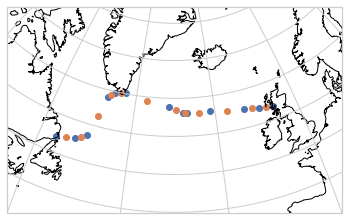

In [27]:
sns.set(style="whitegrid")
central_lon, central_lat = -30, 55
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
extent = [-60, 0, 40, 70]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

lonlat.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat')
lonlat2mean.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat');

In [28]:
t=[]
length=[]

for name,group in ds.isel(ends=0).groupby(ds.isel(ends=0).time):
    t.append(name)
    length.append(group.lat.shape[0])
    

In [29]:
def plot_transports_by_source(total,labcu,gulfs,other,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)
    
    total.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C0',zorder=1)
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    gulfs.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C2',zorder=1)
    other.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C3',zorder=1)
    total.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C0',zorder=10,label='total')
    labcu.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    gulfs.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C2',zorder=10,label='gulf stream')
    other.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C3',zorder=10,label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim(bottom=0)

    total.temp_transport.plot(ax=ax[1],alpha=0.4,color='C0',zorder=1)
    labcu.temp_transport.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    gulfs.temp_transport.plot(ax=ax[1],alpha=0.4,color='C2',zorder=1)
    other.temp_transport.plot(ax=ax[1],alpha=0.4,color='C3',zorder=1)
    total.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C0',zorder=10,label='total')
    labcu.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    gulfs.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C2',zorder=10,label='gulf stream')
    other.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C3',zorder=10,label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim(bottom=0)

    total.salt_transport.plot(ax=ax[2],alpha=0.4,color='C0',zorder=1)
    labcu.salt_transport.plot(ax=ax[2],alpha=0.4,color='C1',zorder=1)
    gulfs.salt_transport.plot(ax=ax[2],alpha=0.4,color='C2',zorder=1)
    other.salt_transport.plot(ax=ax[2],alpha=0.4,color='C3',zorder=1)
    total.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C0',zorder=10,label='total')
    labcu.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C1',zorder=10,label='labrador sea')
    gulfs.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C2',zorder=10,label='gulf stream')
    other.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C3',zorder=10,label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
#     ax[2].set_ylim(bottom=0)

#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [30]:
def plot_total_transport(total,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(1,figsize = (9,7),sharex=True)
    
    total.vol_trans_normal.plot(ax=ax,alpha=0.4,color='C0',zorder=1)
    total.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax,color='C0',zorder=10,label='total')
    lgd = ax.legend(bbox_to_anchor=(1.0, 1.01),loc='upper left')
    ax.set_ylabel('transport [Sv]')
    ax.set_xlabel('time')
#     ax[0].set_ylim(bottom=0)

    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [31]:
def plot_transport_anomalies_by_source(total,labcu,gulfs,other,figname):

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)

    (total.vol_trans_normal - 
     total.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='total')
    (labcu.vol_trans_normal-
     labcu.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='labrador sea')
    (gulfs.vol_trans_normal-
     gulfs.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='gulf stream')
    (other.vol_trans_normal-
     other.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')

    (total.temp_transport-
     total.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='total')
    (labcu.temp_transport-
     labcu.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='labrador sea')
    (gulfs.temp_transport-
     gulfs.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='gulf stream')
    (other.temp_transport-
     other.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')

    (total.salt_transport-
     total.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='total')
    (labcu.salt_transport-
     labcu.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='labrador sea')
    (gulfs.salt_transport-
     gulfs.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='gulf stream')
    (other.salt_transport-
     other.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
   

#     title=fig.suptitle('Transport anomalies across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [32]:
total_sum  = ds.isel(ends=0).groupby("time").sum()
labcu_sum  = ds.isel(ends=0).where(ds.isel(ends=0).LabCu_is_source).groupby("time").sum()
gulfs_sum  = ds.isel(ends=0).where(ds.isel(ends=0).GulfS_is_source).groupby("time").sum()
other_sum  = ds.isel(ends=0).where(ds.isel(ends=0).other_is_source).groupby("time").sum()
total_mean = ds.isel(ends=0).groupby("time").mean()
labcu_mean = ds.isel(ends=0).where(ds.isel(ends=0).LabCu_is_source).groupby("time").mean()
gulfs_mean = ds.isel(ends=0).where(ds.isel(ends=0).GulfS_is_source).groupby("time").mean()
other_mean = ds.isel(ends=0).where(ds.isel(ends=0).other_is_source).groupby("time").mean()

lc60w_sum  = ds.isel(ends=0).where(ds.isel(ends=0).LC60W_is_path).groupby("time").sum()
lcdir_sum  = ds.isel(ends=0).where(ds.isel(ends=0).LCdir_is_path).groupby("time").sum()
lc60w_mean = ds.isel(ends=0).where(ds.isel(ends=0).LC60W_is_path).groupby("time").mean()
lcdir_mean = ds.isel(ends=0).where(ds.isel(ends=0).LCdir_is_path).groupby("time").mean()



In [33]:
total_sum_1  = ds.isel(ends=1).groupby(ds.isel(ends=0).time).sum()
labcu_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).LabCu_is_source).groupby(ds.isel(ends=0).time).sum()
gulfs_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).GulfS_is_source).groupby(ds.isel(ends=0).time).sum()
other_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).other_is_source).groupby(ds.isel(ends=0).time).sum()
total_mean_1 = ds.isel(ends=1).groupby(ds.isel(ends=0).time).mean()
labcu_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).LabCu_is_source).groupby(ds.isel(ends=0).time).mean()
gulfs_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).GulfS_is_source).groupby(ds.isel(ends=0).time).mean()
other_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).other_is_source).groupby(ds.isel(ends=0).time).mean()

lc60w_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).LC60W_is_path).groupby(ds.isel(ends=0).time).sum()
lcdir_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).LCdir_is_path).groupby(ds.isel(ends=0).time).sum()
lc60w_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).LC60W_is_path).groupby(ds.isel(ends=0).time).mean()
lcdir_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).LCdir_is_path).groupby(ds.isel(ends=0).time).mean()


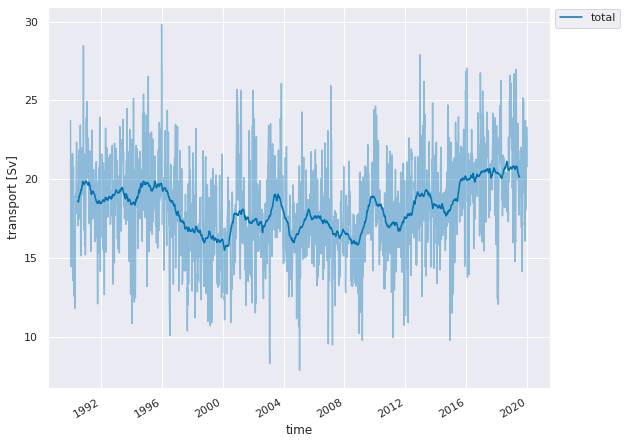

In [34]:
plot_total_transport(total_sum,
                    'total_transport_annualmean'+range_str)

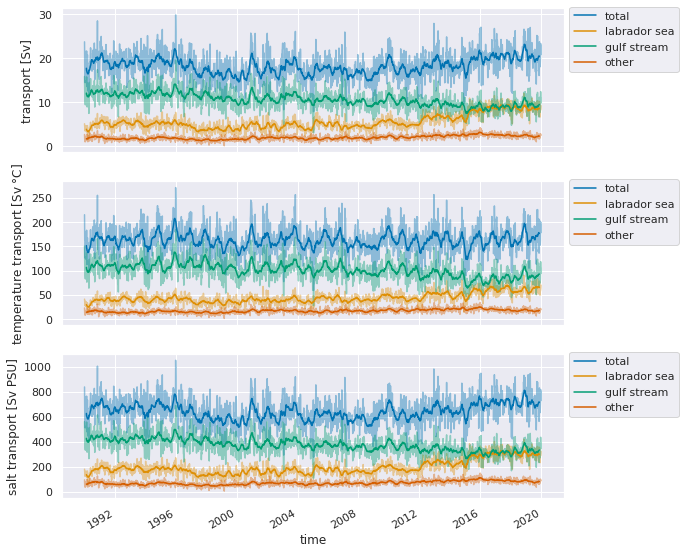

In [35]:
plot_transports_by_source(total_sum,labcu_sum,gulfs_sum,other_sum,
                          'plot_transports_by_source_'+range_str)

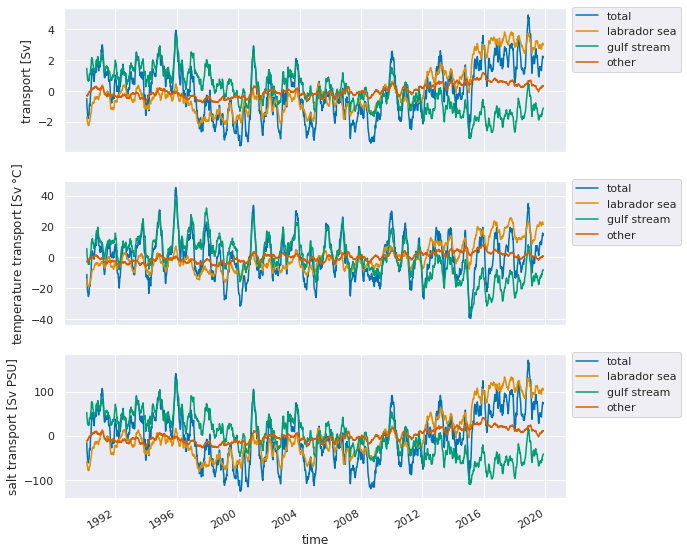

In [36]:
plot_transport_anomalies_by_source(total_sum,labcu_sum,gulfs_sum,other_sum,
                                   'plot_transport_anomalies_by_source_'+range_str)

In [37]:
def plot_transports_by_path(labcu,lc60w,lcdir,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)
    
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    lc60w.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C4',zorder=1)
    lcdir.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C9',zorder=1)
    labcu.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    lc60w.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C9',zorder=10,label='direct path')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim(bottom=0)

    labcu.temp_transport.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    lc60w.temp_transport.plot(ax=ax[1],alpha=0.4,color='C4',zorder=1)
    lcdir.temp_transport.plot(ax=ax[1],alpha=0.4,color='C9',zorder=1)
    labcu.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    lc60w.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C9',zorder=10,label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim(bottom=0)

    labcu.salt_transport.plot(ax=ax[2],alpha=0.4,color='C1',zorder=1)
    lc60w.salt_transport.plot(ax=ax[2],alpha=0.4,color='C4',zorder=1)
    lcdir.salt_transport.plot(ax=ax[2],alpha=0.4,color='C9',zorder=1)
    labcu.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C1',zorder=10,label='labrador sea')
    lc60w.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C9',zorder=10,label='direct path')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
#     ax[2].set_ylim(bottom=0)

#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


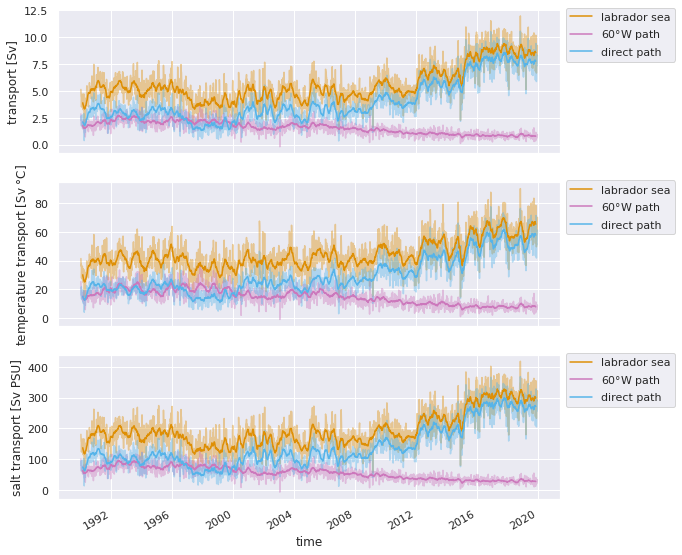

In [38]:
plot_transports_by_path(labcu_sum,lc60w_sum,lcdir_sum,'plot_transports_by_lcpath_'+range_str)

In [39]:
def plot_transport_mean_properties_by_source(total_sum ,labcu_sum ,gulfs_sum ,other_sum ,
                                             total_mean,labcu_mean,gulfs_mean,other_mean,
                                            figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    total_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='total')
    labcu_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='labrador sea')
    gulfs_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='gulf stream')
    other_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (total_mean.temp_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='total')
    (labcu_mean.temp_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='labrador sea')
    (gulfs_mean.temp_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='gulf stream')
    (other_mean.temp_transport.rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (total_mean.salt_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='total')
    (labcu_mean.salt_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='labrador sea')
    (gulfs_mean.salt_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='gulf stream')
    (other_mean.salt_transport.rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='other')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
    total_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='total')
    labcu_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='gulf stream')
    other_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='other')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')

    total_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='total')
    labcu_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='gulf stream')
    other_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='other')
    lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

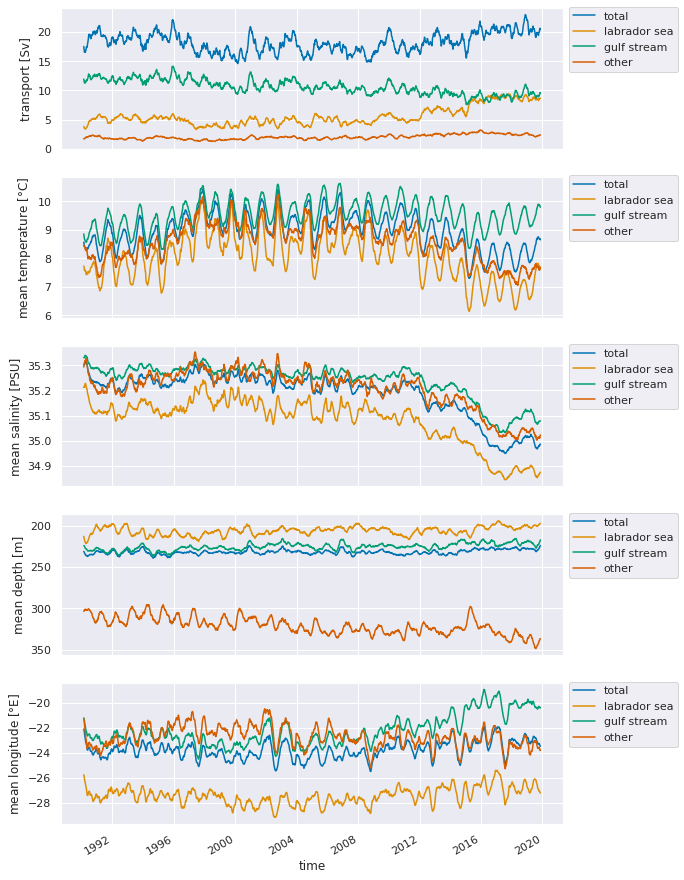

In [40]:
plot_transport_mean_properties_by_source(total_sum ,labcu_sum ,gulfs_sum ,other_sum ,
                                         total_mean,labcu_mean,gulfs_mean,other_mean,
                                        'transportweighted_mean_properties_by_source_'+range_str)

In [41]:
def plot_transport_mean_properties_by_path(labcu_sum ,lc60w_sum ,lcdir_sum ,
                                             labcu_mean,lc60w_mean,lcdir_mean,figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    labcu_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C1',label='labrador sea')
    lc60w_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C4',label='60$\degree$W path')
    lcdir_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C9',label='direct')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (labcu_mean.temp_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],color='C1',label='labrador sea')
    (lc60w_mean.temp_transport.rolling(time=19,center=True).mean()/lc60w_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],color='C4',label='60$\degree$W path')
    (lcdir_mean.temp_transport.rolling(time=19,center=True).mean()/lcdir_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],color='C9',label='direct')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (labcu_mean.salt_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],color='C1',label='labrador sea')
    (lc60w_mean.salt_transport.rolling(time=19,center=True).mean()/lc60w_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],color='C4',label='60$\degree$W path')
    (lcdir_mean.salt_transport.rolling(time=19,center=True).mean()/lcdir_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],color='C9',label='direct')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
    labcu_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],color='C1',label='labrador sea')
    lc60w_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],color='C4',label='60$\degree$W path')
    lcdir_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],color='C9',label='direct')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')

    labcu_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],color='C1',label='labrador sea')
    lc60w_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],color='C4',label='60$\degree$W path')
    lcdir_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],color='C9',label='direct')
    lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

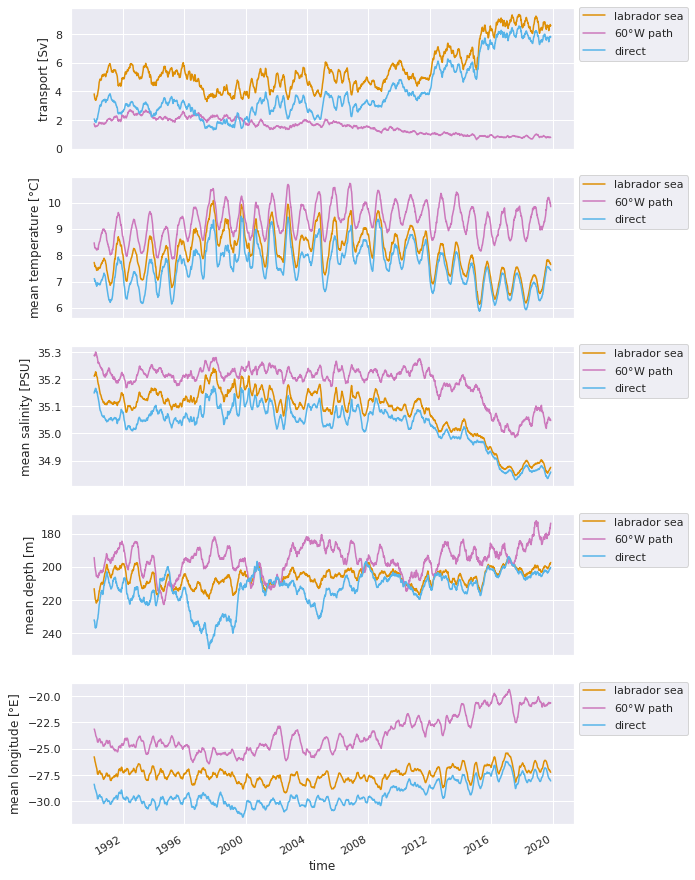

In [42]:
plot_transport_mean_properties_by_path(labcu_sum ,lc60w_sum ,lcdir_sum ,
                                       labcu_mean,lc60w_mean,lcdir_mean,
                                       'transportweighted_mean_properties_by_path_'+range_str)

In [43]:
total_sum

<xarray.Dataset>
Dimensions:           (time: 2189)
Coordinates:
  * time              (time) datetime64[ns] 1990-01-03T12:00:00 ... 2019-12-2...
Data variables: (12/31)
    lat               (time) float32 1.784e+05 1.681e+05 ... 1.615e+05 1.528e+05
    lon               (time) float32 -6.905e+04 -6.444e+04 ... -6.124e+04
    mxl               (time) float32 8.13e+05 8.864e+05 ... 4.869e+05 4.637e+05
    salt              (time) float32 1.085e+05 1.023e+05 ... 9.716e+04 9.194e+04
    temp              (time) float32 2.775e+04 2.614e+04 ... 2.321e+04 2.172e+04
    uvel              (time) float32 -0.00043 -0.001696 ... 0.001072 0.001172
    ...                ...
    depth_transport   (time) float64 5.297e+03 4.166e+03 ... 4.46e+03 4.813e+03
    lon_transport     (time) float64 -544.9 -421.5 -431.3 ... -472.9 -489.4
    tempxvol          (time) float64 6.971e+03 7.412e+03 ... 6.735e+03 6.488e+03
    saltxvol          (time) float64 2.818e+04 3.014e+04 ... 2.852e+04 2.827e+04
    depthxvol         (time) float64 1.925e+05 2.101e+05 ... 1.945e+05 1.949e+05
    lonxvol           (time) float64 -1.85e+04 -1.972e+04 ... -1.872e+04
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [44]:
def plot_transport_mean_source_properties_by_source(total_sum ,labcu_sum ,gulfs_sum ,
                                             total_mean,labcu_mean,gulfs_mean,
                                            figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    total_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='total')
    labcu_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='labrador sea')
    gulfs_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='gulf stream')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (total_mean.temp_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='total')
    (labcu_mean.temp_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='labrador sea')
    (gulfs_mean.temp_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='gulf stream')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (total_mean.salt_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='total')
    (labcu_mean.salt_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='labrador sea')
    (gulfs_mean.salt_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='gulf stream')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
    total_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='total')
    labcu_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='gulf stream')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')

    total_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='total')
    labcu_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='gulf stream')
    lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

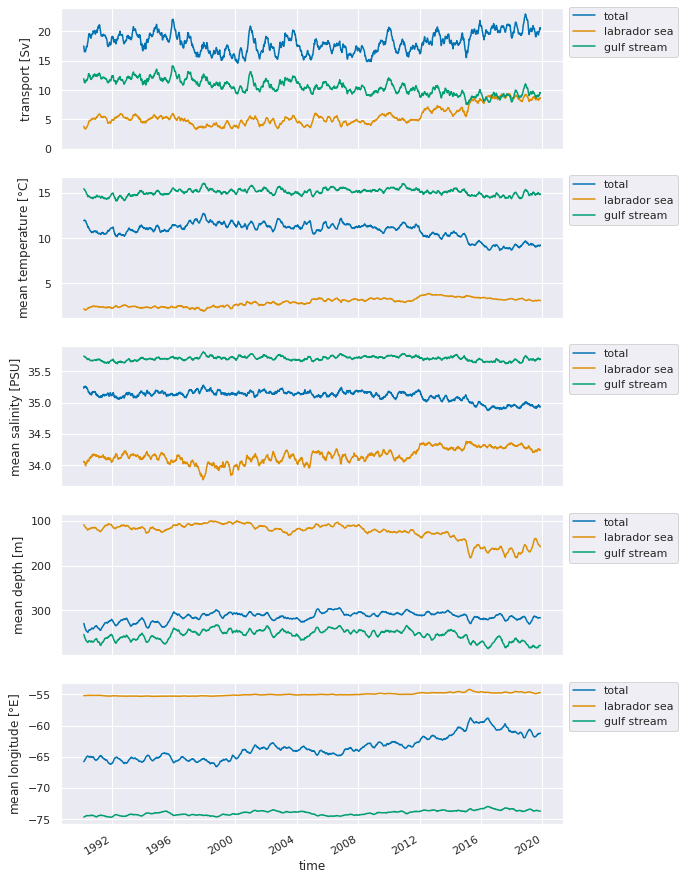

In [45]:
plot_transport_mean_source_properties_by_source(total_sum_1 ,labcu_sum_1 ,gulfs_sum_1 ,
                                         total_mean_1,labcu_mean_1,gulfs_mean_1,
                                        'source_properties_by_source'+range_str)

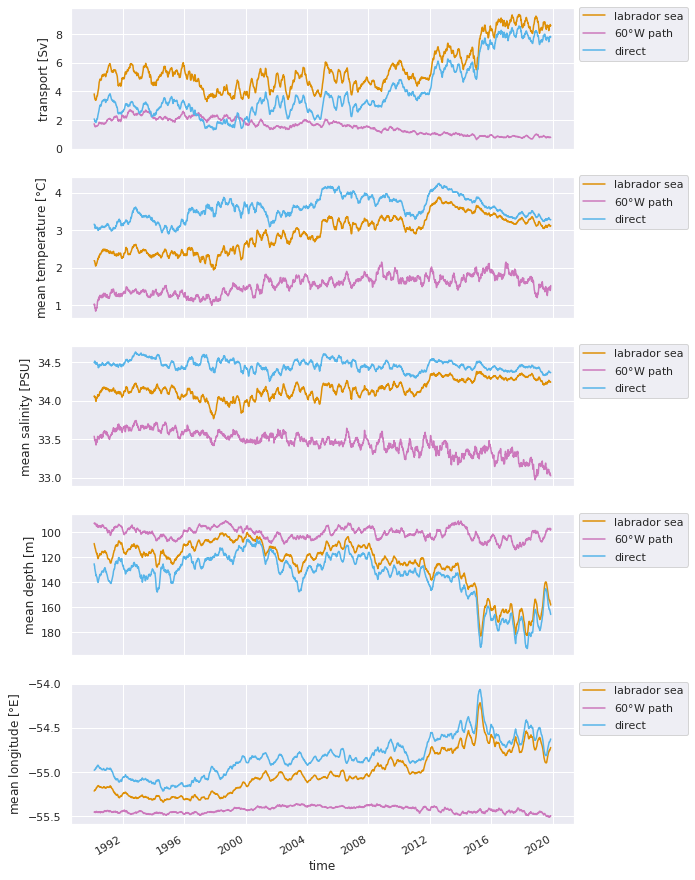

In [46]:
plot_transport_mean_properties_by_path(labcu_sum_1 ,lc60w_sum_1 ,lcdir_sum_1 ,
                                       labcu_mean_1,lc60w_mean_1,lcdir_mean_1,
                                       'source_properties_by_path_'+range_str)

In [47]:
def plot_temperatures_by_source(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean temperature\n at OSNAP east [$\degree$C]')
    ax[0].set_xlabel('')
    ax[0].set_ylim((1.5,16.5))

    (total_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean temperature\n at source [$\degree$C]')
    ax[1].set_xlabel('')
    ax[1].set_ylim((1.5,16.5))

    ((total_mean_b.temp_transport-total_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C0',
                                                                             label='total')
    ((labcu_mean_b.temp_transport-labcu_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='labrador sea')
    ((gulfs_mean_b.temp_transport-gulfs_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C2',
                                                                             label='gulf stream')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean temperature\n change [$\degree$C]')
    ax[2].set_xlabel('')
    ax[2].set_ylim((-7.5,7.5))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [48]:
def plot_salinities_by_source(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean salinity\n at OSNAP east [PSU]')
    ax[0].set_xlabel('')
    ax[0].set_ylim((33.9,35.9))

    (total_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean salinity\n at source [PSU]')
    ax[1].set_xlabel('')
    ax[1].set_ylim((33.8,35.9))

    ((total_mean_b.salt_transport-total_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C0',
                                                                             label='total')
    ((labcu_mean_b.salt_transport-labcu_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='labrador sea')
    ((gulfs_mean_b.salt_transport-gulfs_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C2',
                                                                             label='gulf stream')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean salinity\n change [PSU]')
    ax[2].set_xlabel('')
    ax[2].set_ylim((-0.65,1.35))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

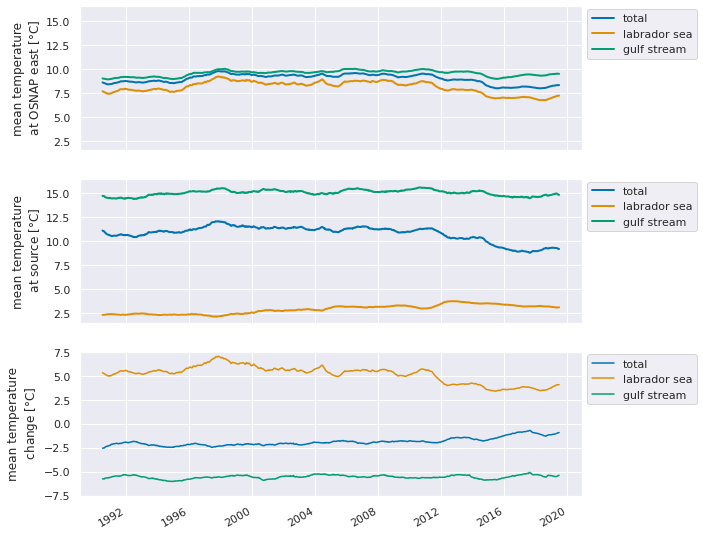

In [49]:
plot_temperatures_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                73,
                                'temperature_by_source_annualmean')

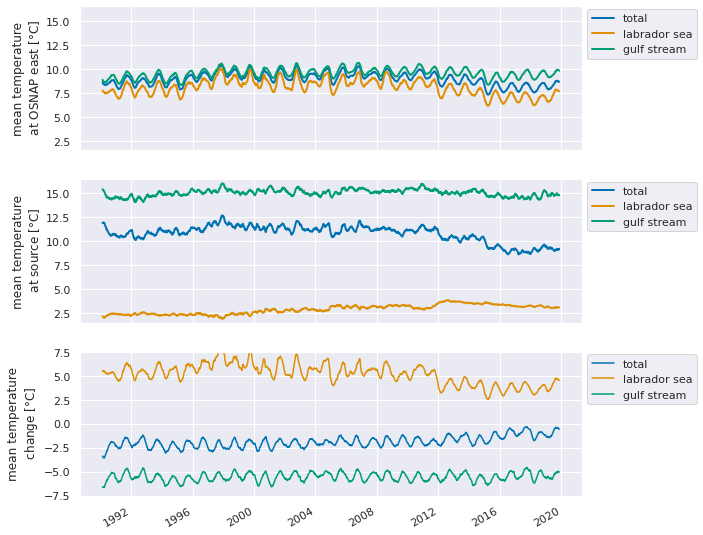

In [50]:
plot_temperatures_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                19,
                                'temperature_by_source_seasonalmean')

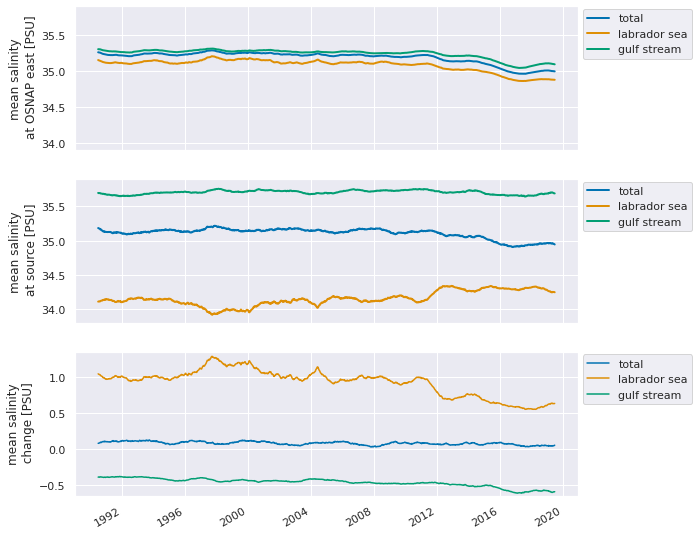

In [51]:
plot_salinities_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                73,
                                'salinity_by_source_annualmean')

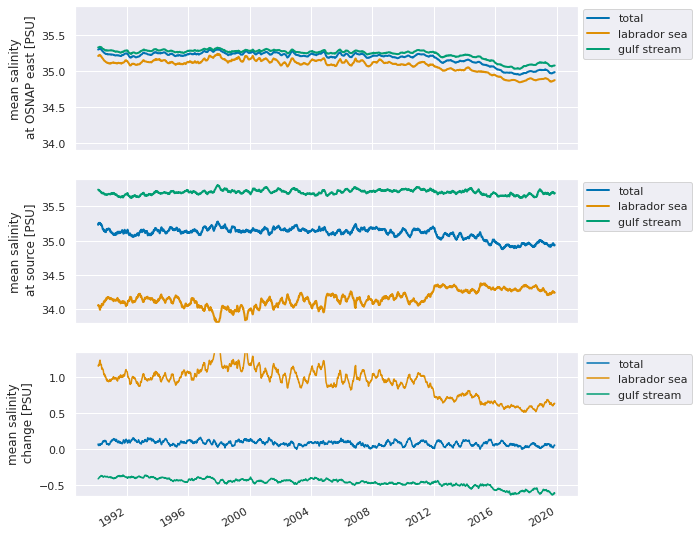

In [52]:
plot_salinities_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                19,
                                'salinity_by_source_seasonalmean')

In [53]:
def plot_temperatures_by_path(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (labcu_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean temperature\n at OSNAP east [$\degree$C]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim((1.5,16.5))

    (total_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean temperature\n at source [$\degree$C]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim((1.5,16.5))

    ((total_mean_b.temp_transport-total_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='total')
    ((labcu_mean_b.temp_transport-labcu_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C4',
                                                                             label='60$\degree$W path')
    ((gulfs_mean_b.temp_transport-gulfs_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C9',
                                                                             label='direct path')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean temperature\n change [$\degree$C]')
    ax[2].set_xlabel('')
#     ax[2].set_ylim((-7.5,7.5))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [54]:
def plot_salinities_by_path(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (labcu_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean salinity\n at OSNAP east [PSU]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim((1.5,16.5))

    (total_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean salinity\n at source [PSU]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim((1.5,16.5))

    ((total_mean_b.salt_transport-total_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='total')
    ((labcu_mean_b.salt_transport-labcu_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C4',
                                                                             label='60$\degree$W path')
    ((gulfs_mean_b.salt_transport-gulfs_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C9',
                                                                             label='direct path')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean salinity\n change [PSU]')
    ax[2].set_xlabel('')
#     ax[2].set_ylim((-7.5,7.5))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

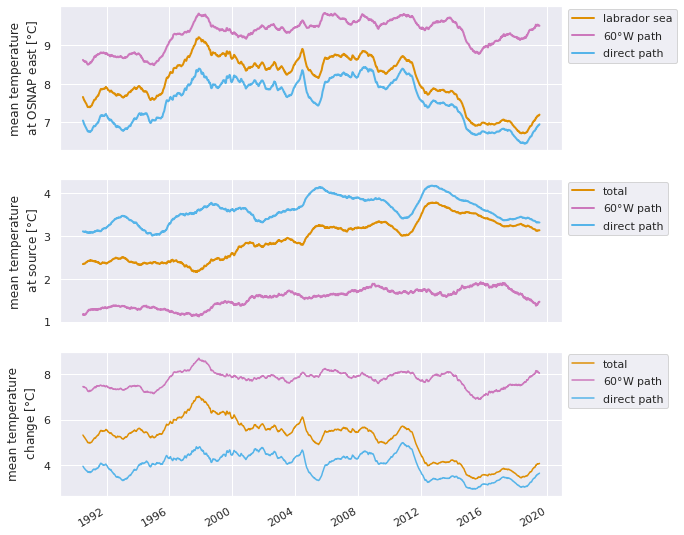

In [55]:
plot_temperatures_by_path(labcu_mean_1,lc60w_mean_1,lcdir_mean_1,
                                labcu_mean,lc60w_mean,lcdir_mean,
                                73,
                                'temperature_by_path_annualmean')

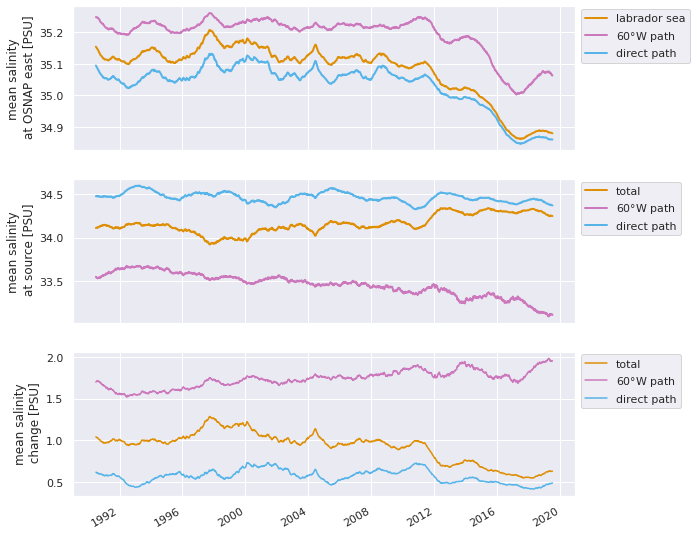

In [56]:
plot_salinities_by_path(labcu_mean_1,lc60w_mean_1,lcdir_mean_1,
                                labcu_mean,lc60w_mean,lcdir_mean,
                                73,
                                'salinity_by_path_annualmean')

In [57]:
total_mean

<xarray.Dataset>
Dimensions:           (time: 2189)
Coordinates:
  * time              (time) datetime64[ns] 1990-01-03T12:00:00 ... 2019-12-2...
Data variables: (12/31)
    lat               (time) float32 58.07 58.05 58.0 58.0 ... 58.16 58.2 58.17
    lon               (time) float32 -22.48 -22.25 -21.55 ... -23.76 -23.31
    mxl               (time) float32 264.6 306.1 323.4 ... 169.5 175.5 176.5
    salt              (time) float32 35.32 35.32 35.34 ... 35.01 35.01 35.0
    temp              (time) float32 9.035 9.027 9.068 ... 8.468 8.364 8.268
    uvel              (time) float32 -1.4e-07 -5.855e-07 ... 3.862e-07 4.461e-07
    ...                ...
    depth_transport   (time) float64 1.724 1.439 1.472 ... 1.654 1.607 1.832
    lon_transport     (time) float64 -0.1774 -0.1455 -0.1572 ... -0.1704 -0.1863
    tempxvol          (time) float64 2.269 2.559 2.898 ... 2.312 2.427 2.47
    saltxvol          (time) float64 9.174 10.41 11.86 ... 9.884 10.28 10.76
    depthxvol         (time) float64 62.66 72.56 82.83 ... 66.16 70.1 74.18
    lonxvol           (time) float64 -6.023 -6.811 -7.663 ... -6.65 -7.127
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

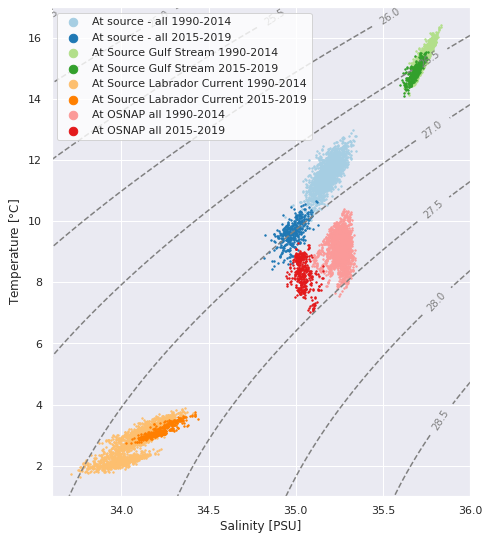

In [58]:
sns.set_palette("Paired")
fig,ax = plt.subplots(figsize=(7.5,9))

sns.set(style="whitegrid")
sns.set_palette("Paired")
T_lim=[0,17.4]
S_lim=[33,36]
Tgrid = np.zeros((100,100)) + np.linspace(T_lim[0],T_lim[1],100)
Sgrid = np.zeros((100,100)) + np.linspace(S_lim[0],S_lim[1],100)
sig0grid = sw.pden(Sgrid,Tgrid.T,0,0) - 1000.0


cs = ax.contour(Sgrid,Tgrid.T,sig0grid,
          colors = 'grey', linestyles = 'dashed',levels=10)
ax.clabel(cs, inline=1, fmt='%1.1f', fontsize=10)

ax.scatter(total_mean_1.salt.isel(time = slice(0,1825,1)),
           total_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C0',
           label='At source - all 1990-2014')
ax.scatter(total_mean_1.salt.isel(time = slice(1825,None,1)),
           total_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C1',
           label='At source - all 2015-2019')
# ax.scatter(gulfs_mean.salt.isel(time = slice(0,1825,1)),
#            gulfs_mean.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Gulf Stream 1990-2014')
# ax.scatter(gulfs_mean.salt.isel(time = slice(1825,None,1)),
#            gulfs_mean.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Gulf Stream 2015-2019')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(0,1825,1)),
           gulfs_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C2',
           label='At Source Gulf Stream 1990-2014')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(1825,None,1)),
           gulfs_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C3',
           label='At Source Gulf Stream 2015-2019')
# ax.scatter(labcu_mean.salt.isel(time = slice(0,1825,1)),
#            labcu_mean.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Labrador Current 1990-2014')
# ax.scatter(labcu_mean.salt.isel(time = slice(1825,None,1)),
#            labcu_mean.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Labrador Current 2015-2019')
ax.scatter(labcu_mean_1.salt.isel(time = slice(0,1825,1)),
           labcu_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C6',
           label='At Source Labrador Current 1990-2014')
ax.scatter(labcu_mean_1.salt.isel(time = slice(1825,None,1)),
           labcu_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C7',
           label='At Source Labrador Current 2015-2019')
ax.scatter(total_mean.salt.isel(time = slice(0,1825,1)),
           total_mean.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C4',
           label='At OSNAP all 1990-2014')
ax.scatter(total_mean.salt.isel(time = slice(1825,None,1)),
           total_mean.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C5',
           label='At OSNAP all 2015-2019')

lgd=ax.legend(markerscale=6.)

ax.set_xlim((33.6,36))
ax.set_ylim((1,17))
ax.set_xlabel('Salinity [PSU]')
ax.set_ylabel('Temperature [$\degree$C]')

figname='TSdiagram_all'

plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')



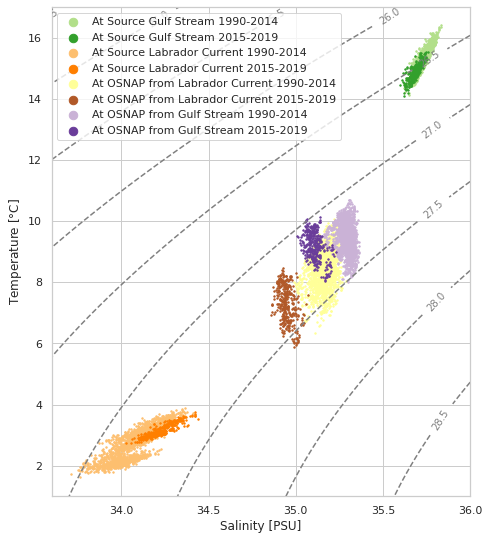

In [59]:
sns.set_palette("Paired")
fig,ax = plt.subplots(figsize=(7.5,9))

sns.set(style="whitegrid")
sns.set_palette("Paired")
T_lim=[0,17.4]
S_lim=[33,36]
Tgrid = np.zeros((100,100)) + np.linspace(T_lim[0],T_lim[1],100)
Sgrid = np.zeros((100,100)) + np.linspace(S_lim[0],S_lim[1],100)
sig0grid = sw.pden(Sgrid,Tgrid.T,0,0) - 1000.0


cs = ax.contour(Sgrid,Tgrid.T,sig0grid,
          colors = 'grey', linestyles = 'dashed',levels=10)
ax.clabel(cs, inline=1, fmt='%1.1f', fontsize=10)

# ax.scatter(total_mean_1.salt.isel(time = slice(0,1825,1)),
#            total_mean_1.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            color='C0',
#            label='At source - all 1990-2014')
# ax.scatter(total_mean_1.salt.isel(time = slice(1825,None,1)),
#            total_mean_1.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            color='C1',
#            label='At source - all 2015-2019')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(0,1825,1)),
           gulfs_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C2',
           label='At Source Gulf Stream 1990-2014')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(1825,None,1)),
           gulfs_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C3',
           label='At Source Gulf Stream 2015-2019')
ax.scatter(labcu_mean_1.salt.isel(time = slice(0,1825,1)),
           labcu_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C6',
           label='At Source Labrador Current 1990-2014')
ax.scatter(labcu_mean_1.salt.isel(time = slice(1825,None,1)),
           labcu_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C7',
           label='At Source Labrador Current 2015-2019')
# ax.scatter(total_mean.salt.isel(time = slice(0,1825,1)),
#            total_mean.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            color='C4',
#            label='At OSNAP all 1990-2014')
# ax.scatter(total_mean.salt.isel(time = slice(1825,None,1)),
#            total_mean.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            color='C5',
#            label='At OSNAP all 2015-2019')
ax.scatter(labcu_mean.salt.isel(time = slice(0,1825,1)),
           labcu_mean.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C10',
           label='At OSNAP from Labrador Current 1990-2014')
ax.scatter(labcu_mean.salt.isel(time = slice(1825,None,1)),
           labcu_mean.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C11',
           label='At OSNAP from Labrador Current 2015-2019')
ax.scatter(gulfs_mean.salt.isel(time = slice(0,1825,1)),
           gulfs_mean.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C8',
           label='At OSNAP from Gulf Stream 1990-2014')
ax.scatter(gulfs_mean.salt.isel(time = slice(1825,None,1)),
           gulfs_mean.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C9',
           label='At OSNAP from Gulf Stream 2015-2019')
lgd = ax.legend(markerscale=6.)

ax.set_xlim((33.6,36))
ax.set_ylim((1,17))
ax.set_xlabel('Salinity [PSU]')
ax.set_ylabel('Temperature [$\degree$C]');

figname='TSdiagram_source'

plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')



In [60]:
other_mean.salt_transport

<xarray.DataArray 'salt_transport' (time: 2189)>
array([0.27103556, 0.15977977, 0.2018943 , ..., 0.27481166, 0.24636167,
       0.28202181])
Coordinates:
  * time     (time) datetime64[ns] 1990-01-03T12:00:00 ... 2019-12-29T12:00:00
Attributes:
    units:      PSU
    long_name:  salinity

In [61]:
conda list

# packages in environment at /opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                      1_llvm    conda-forge
ansiwrap                  0.8.4                      py_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h497a2fe_2    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
basemap                   1.2.2      